In [1]:
# Imports & settings 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10,5)
sns.set(style="darkgrid")

In [2]:
# Load CSVs 

customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
geo = pd.read_csv("olist_geolocation_dataset.csv")

# Quick shapes
print("rows:", 
      customers.shape, orders.shape, order_items.shape, products.shape, sellers.shape, payments.shape, reviews.shape, geo.shape)

rows: (99441, 5) (99441, 8) (112650, 7) (32951, 9) (3095, 4) (103886, 5) (99224, 7) (1000163, 5)


In [3]:
# Parse dates & quick cleaning

# Standardize date columns in orders & order_items & reviews
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'], errors='coerce')
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'], errors='coerce')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], errors='coerce')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'], errors='coerce')

# Convert payments and items numeric columns
order_items['price'] = pd.to_numeric(order_items['price'], errors='coerce')
order_items['freight_value'] = pd.to_numeric(order_items['freight_value'], errors='coerce')
payments['payment_value'] = pd.to_numeric(payments['payment_value'], errors='coerce')

# Drop exact duplicates
customers.drop_duplicates(inplace=True)
orders.drop_duplicates(inplace=True)
order_items.drop_duplicates(inplace=True)
payments.drop_duplicates(inplace=True)
reviews.drop_duplicates(inplace=True)

# Quick null report for main tables
print("Orders nulls:\n", orders.isnull().sum())
print("Order items nulls:\n", order_items.isnull().sum())
print("Payments nulls:\n", payments.isnull().sum())
print("Reviews nulls:\n", reviews.isnull().sum())

Orders nulls:
 order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
Order items nulls:
 order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
Payments nulls:
 order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
Reviews nulls:
 review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


In [4]:
# Create order-level sales table

# Aggregate order_items to order level to get order_sales and quantity
order_sales = order_items.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum',
    'product_id': 'count'   # number of lines/items
}).rename(columns={'price':'order_sales', 'product_id':'items_count'}).reset_index()

# Merge with orders and payments and customers
orders_full = orders.merge(order_sales, how='left', left_on='order_id', right_on='order_id')
orders_full = orders_full.merge(payments.groupby('order_id').agg({'payment_value':'sum'}).reset_index(),
                                how='left', on='order_id')
orders_full = orders_full.merge(customers[['customer_id','customer_unique_id']], how='left', on='customer_id')

# If order_sales missing (edge cases), fill with payment_value
orders_full['order_sales'] = orders_full['order_sales'].fillna(orders_full['payment_value']).fillna(0)
orders_full['items_count'] = orders_full['items_count'].fillna(0).astype(int)

orders_full['order_year'] = orders_full['order_purchase_timestamp'].dt.year
orders_full['order_month'] = orders_full['order_purchase_timestamp'].dt.to_period('M').astype(str)

print("Orders_full shape:", orders_full.shape)
orders_full.head()

Orders_full shape: (99441, 15)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_sales,freight_value,items_count,payment_value,customer_unique_id,order_year,order_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,8.72,1,38.71,7c396fd4830fd04220f754e42b4e5bff,2017,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,22.76,1,141.46,af07308b275d755c9edb36a90c618231,2018,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,19.22,1,179.12,3a653a41f6f9fc3d2a113cf8398680e8,2018,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,45.00,27.20,1,72.20,7c142cf63193a1473d2e66489a9ae977,2017,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,19.90,8.72,1,28.62,72632f0f9dd73dfee390c9b22eb56dd6,2018,2018-02


In [5]:
# Feature engineering (delivery time, refund flag, order age) 

# Delivery time in days
orders_full['delivery_days'] = (orders_full['order_delivered_customer_date'] - orders_full['order_purchase_timestamp']).dt.days
orders_full['delivery_days'] = orders_full['delivery_days'].fillna(-1)  # -1 means not delivered

# Returned/invalid orders – some entries have status = 'canceled' or 'unavailable'
orders_full['is_canceled'] = orders_full['order_status'].str.lower().eq('canceled').astype(int)

# Order age (recency) - relative to max order date in dataset
max_date = orders_full['order_purchase_timestamp'].max()
orders_full['recency_days'] = (max_date - orders_full['order_purchase_timestamp']).dt.days

# Basic sanity
print("Delivery days stats:", orders_full['delivery_days'].replace(-1, np.nan).describe())

Delivery days stats: count    96476.000000
mean        12.094086
std          9.551746
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_days, dtype: float64


In [6]:
# Customer-level aggregation (lifetime metrics) 

# Aggregate by customer_unique_id
cust = orders_full.groupby('customer_unique_id').agg({
    'order_id':'nunique',
    'order_sales':'sum',
    'items_count':'sum',
    'recency_days':'min',    
    'order_purchase_timestamp':'max'  # last purchase
}).rename(columns={'order_id':'total_orders','order_sales':'lifetime_sales','items_count':'lifetime_items',
                   'order_purchase_timestamp':'last_order_date'}).reset_index()

# Add first order date and recency as days since last
first_order = orders_full.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index().rename(columns={'order_purchase_timestamp':'first_order_date'})
cust = cust.merge(first_order, on='customer_unique_id', how='left')
cust['days_since_last_order'] = (max_date - cust['last_order_date']).dt.days
cust['customer_tenure_days'] = (cust['last_order_date'] - cust['first_order_date']).dt.days.replace(np.nan,0)

# AOV per customer
cust['avg_order_value'] = cust['lifetime_sales'] / cust['total_orders']

# Repeat rate (number of customers with >1 orders)
repeat_rate = (cust['total_orders'] > 1).mean()
print(f"Repeat rate: {repeat_rate:.2%}")

cust.head()

Repeat rate: 3.12%


,customer_unique_id,total_orders,lifetime_sales,lifetime_items,recency_days,last_order_date,first_order_date,days_since_last_order,customer_tenure_days,avg_order_value
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,160,2018-05-10 10:56:27,2018-05-10 10:56:27,160,0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,163,2018-05-07 11:11:27,2018-05-07 11:11:27,163,0,18.90
2,0000f46a3911fa3c0805444483337064,1,69.00,1,585,2017-03-10 21:05:03,2017-03-10 21:05:03,585,0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,369,2017-10-12 20:29:41,2017-10-12 20:29:41,369,0,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,336,2017-11-14 19:45:42,2017-11-14 19:45:42,336,0,180.00


In [7]:
# Save cleaned outputs

orders_full.to_csv("orders_full_clean.csv", index=False)
cust.to_csv("customers_summary.csv", index=False)

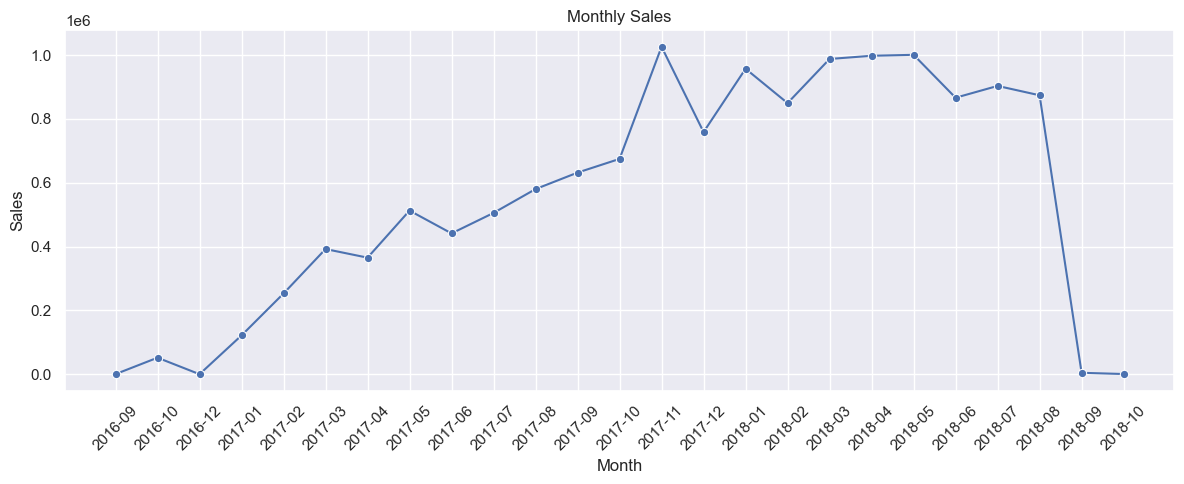

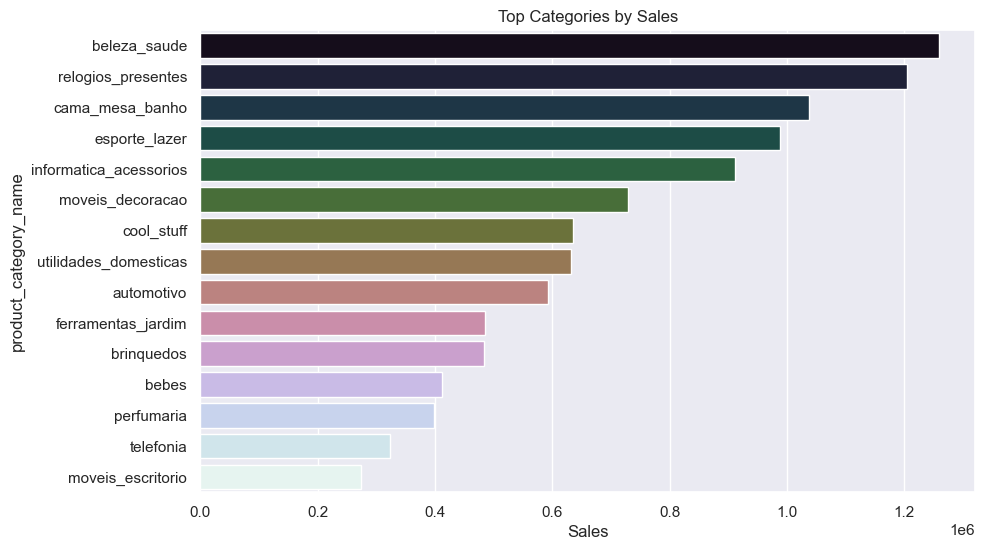

In [9]:
# EDA Visuals 

# Sales over time
sales_time = orders_full.groupby('order_month')['order_sales'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=sales_time, x='order_month', y='order_sales', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Sales")
plt.ylabel("Sales")
plt.xlabel("Month")
plt.tight_layout()
plt.savefig("Monthly Sales.png")
plt.show()

# Sales by Category (via order_items -> product -> category)
prod_cat = order_items.merge(products[['product_id','product_category_name']], how='left', on='product_id')
cat_sales = prod_cat.groupby('product_category_name')['price'].sum().sort_values(ascending=False).head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=cat_sales.values, y=cat_sales.index, palette="cubehelix")
plt.title("Top Categories by Sales")
plt.xlabel("Sales")
plt.savefig("Top Categories by Sales.png")
plt.show()

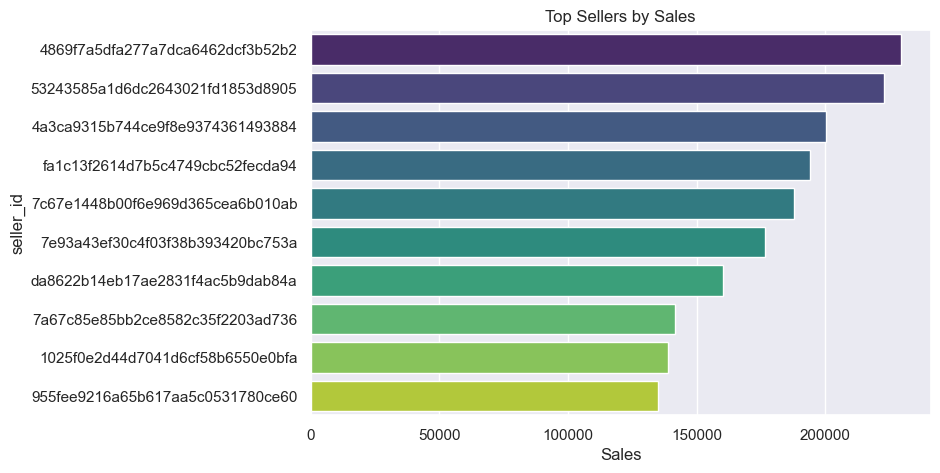

In [11]:
# Top sellers by sales
items_sellers = order_items.merge(sellers, on='seller_id', how='left')
sellers_sales = items_sellers.groupby('seller_id')['price'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=sellers_sales.values, y=sellers_sales.index, palette="viridis")
plt.title("Top Sellers by Sales")
plt.xlabel("Sales")
plt.savefig("Top Sellers by Sales.png")
plt.show()

In [12]:
# RFM segmentation

# Build RFM table using last order date
rfm = orders_full.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
    'order_id': 'nunique',
    'order_sales': 'sum'
}).reset_index().rename(columns={
    'order_purchase_timestamp':'Recency',
    'order_id':'Frequency',
    'order_sales':'Monetary'
})
# Convert Recency so that lower is better. We'll compute quintiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])   # recent -> higher score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
rfm['RFM_Score'] = rfm['R_Score'].astype(int)*100 + rfm['F_Score'].astype(int)*10 + rfm['M_Score'].astype(int)

# KMeans on scaled R,F,M for cluster segmentation (alternative)
scaler = StandardScaler()
rfm_sc = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']].fillna(0))
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Segment'] = kmeans.fit_predict(rfm_sc)

# Display segments size
print(rfm.groupby('Segment').size())
rfm.head()

  File "C:\Users\101\anaconda3\envs\tensorflow\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Segment
0    52145
1    38749
2     2964
3     2238
dtype: int64


,customer_unique_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,129.90,4,1,4,414,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,18.90,4,1,1,411,0
2,0000f46a3911fa3c0805444483337064,585,1,69.00,1,1,2,112,1
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,25.99,2,1,1,211,1
4,0004aac84e0df4da2b147fca70cf8255,336,1,180.00,2,1,5,215,1


In [13]:
# Sentiment analysis on reviews

# Clean and apply TextBlob sentiment on review_comment_message
reviews['review_comment_message'] = reviews['review_comment_message'].astype(str)
reviews['review_clean'] = reviews['review_comment_message'].str.lower().str.replace(r'[^a-z0-9\s]', ' ', regex=True)
reviews['polarity'] = reviews['review_clean'].apply(lambda x: TextBlob(x).sentiment.polarity if x and x.strip()!='nan' else 0)
reviews['sentiment'] = reviews['polarity'].apply(lambda p: 'positive' if p>0.05 else ('negative' if p<-0.05 else 'neutral'))

# Merge review sentiment to orders
orders_reviews = orders_full.merge(reviews[['order_id','polarity','sentiment']], on='order_id', how='left')
print(orders_reviews['sentiment'].value_counts(dropna=False))

sentiment
neutral     95646
positive     3132
NaN           768
negative      446
Name: count, dtype: int64


In [14]:
# Business insights extraction

# Top categories with high returns/cancellations
cat_cancel = (orders_full[orders_full['is_canceled']==1]
              .merge(order_items[['order_id','product_id']], on='order_id', how='left')
              .merge(products[['product_id','product_category_name']], on='product_id', how='left')
             ).groupby('product_category_name').size().sort_values(ascending=False).head(10)
print("Top categories by cancellations:\n", cat_cancel)

# Average delivery days by category
order_items_prod = order_items.merge(products[['product_id','product_category_name']], on='product_id', how='left')
orders_with_items = orders_full.merge(order_items_prod[['order_id','product_category_name']], on='order_id', how='left')
delivery_by_cat = orders_with_items.groupby('product_category_name')['delivery_days'].apply(lambda x: x[x>=0].mean()).sort_values()
print("Avg delivery days by category:\n", delivery_by_cat.head(10))

Top categories by cancellations:
 product_category_name
esporte_lazer             51
utilidades_domesticas     49
informatica_acessorios    46
moveis_decoracao          36
beleza_saude              36
brinquedos                34
automotivo                30
relogios_presentes        21
bebes                     20
ferramentas_jardim        19
dtype: int64
Avg delivery days by category:
 product_category_name
artes_e_artesanato                               5.291667
la_cuisine                                       7.071429
livros_importados                                7.666667
portateis_cozinha_e_preparadores_de_alimentos    7.785714
fashion_roupa_infanto_juvenil                    8.142857
pc_gamer                                         8.750000
artigos_de_festas                                8.904762
alimentos                                        9.100200
construcao_ferramentas_iluminacao                9.245847
portateis_casa_forno_e_cafe                      9.397260
Name: d

In [17]:
# Export final summary tables

rfm.to_csv("customer_rfm_segments.csv", index=False)
orders_reviews.to_csv("orders_with_reviews_sentiment.csv", index=False)
top_products[['product_id','price']].to_csv("top_products.csv", index=False)